In [123]:
!pip install numpy pandas matplotlib seaborn ipywidgets
import pandas as pd
import numpy as np

In [124]:
dataset = pd.read_csv("Crimes_-_2001_to_Present_20250314.csv")

In [125]:
# Preprocessing
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Step 4: Standardizing text columns
dataset['Primary Type'] = dataset['Primary Type'].str.upper()
dataset['Location Description'] = dataset['Location Description'].str.upper()

# Step 5: Remove duplicates
dataset = dataset.drop_duplicates()

In [126]:
# Filter data

# exclude those without latitude
dataset = dataset[~dataset["Latitude"].isna()]

# exclude those in "rare locations" (< 20 occurrences, will make location processing simpler)
rare_locations = dataset.groupby("Location Description").filter(lambda x: len(x) < 20)["Location Description"].tolist()
dataset = dataset[~dataset["Location Description"].isin(rare_locations)]

In [127]:
pd.set_option('display.max_columns', None)
dataset.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
3,13203321,JG415333,2023-09-06 17:00:00,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,122,1.0,42.0,32.0,14,1174694.0,1901831.0,2023,11/04/2023 03:40:18 PM,41.886018,-87.633938,"(41.886018055, -87.633937881)"
4,13204489,JG416325,2023-09-06 11:00:00,0000X E 8TH ST,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,123,1.0,4.0,32.0,06,1176857.0,1896680.0,2023,11/04/2023 03:40:18 PM,41.871835,-87.626151,"(41.871834768, -87.62615082)"
5,11695116,JC272771,2019-05-21 08:20:00,018XX S CALIFORNIA AVE,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE,False,False,1023,10.0,25.0,29.0,05,1157982.0,1890961.0,2019,01/19/2024 03:40:50 PM,41.856547,-87.695605,"(41.856547057, -87.695604526)"
6,12419690,JE295655,2021-07-07 10:30:00,132XX S GREENWOOD AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,RESIDENCE,False,False,533,5.0,10.0,54.0,17,1186051.0,1817781.0,2021,01/19/2024 03:40:50 PM,41.655116,-87.594883,"(41.65511579, -87.594883198)"
7,12729745,JF279458,2022-06-14 14:47:00,035XX N CENTRAL AVE,0340,ROBBERY,ATTEMPT STRONG ARM - NO WEAPON,BANK,True,False,1633,16.0,30.0,15.0,03,1138391.0,1923142.0,2022,01/19/2024 03:40:50 PM,41.945232,-87.766735,"(41.945232412, -87.766734668)"


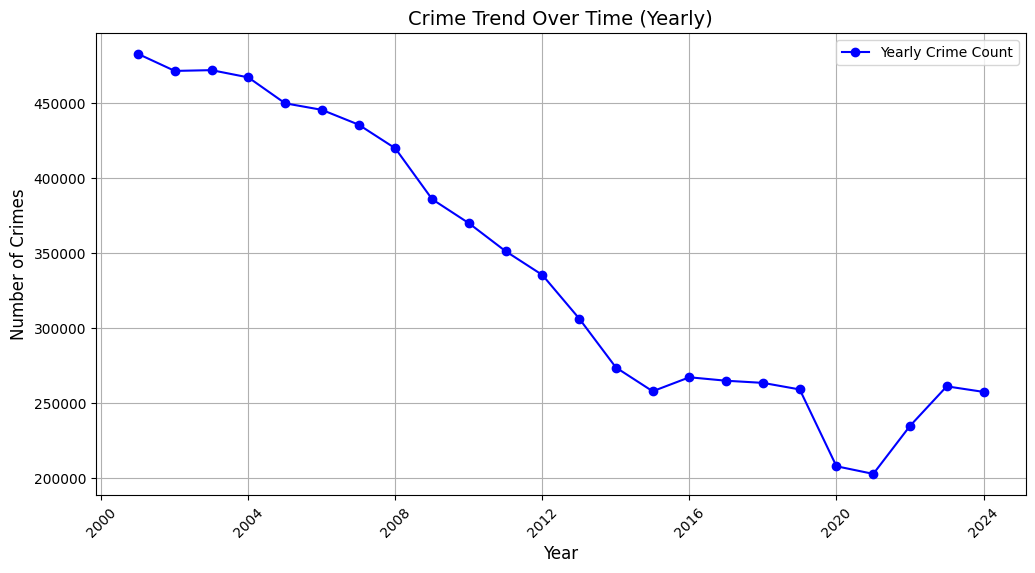

In [129]:
# Extract year
crimes_by_year = dataset["Date"].dt.to_period("Y")  # "Y" for yearly

# Aggregate crime counts per year and sort by time
crime_trend_yearly = crimes_by_year.value_counts().sort_index()

# Remove the last element
crime_trend_yearly = crime_trend_yearly.iloc[:-1]

# Convert to a datetime index for plotting
crime_trend_yearly.index = crime_trend_yearly.index.to_timestamp()

# Plot the yearly crime trend
plt.figure(figsize=(12, 6))
plt.plot(crime_trend_yearly, marker="o", linestyle="-", color="blue", label="Yearly Crime Count")

# Formatting the plot
plt.title("Crime Trend Over Time (Yearly)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Crimes", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

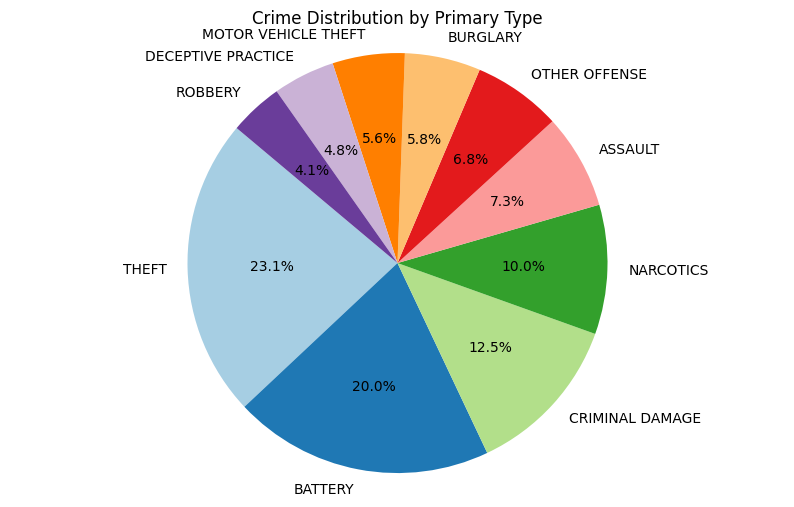

In [130]:
import matplotlib.pyplot as plt

# Group by Primary Type and count occurrences
crime_counts = dataset["Primary Type"].value_counts()

# Optional: Show only top 10 crime types for readability
crime_counts = crime_counts[:10]

# Plot the pie chart
plt.figure(figsize=(10, 6))
plt.pie(crime_counts, labels=crime_counts.index, autopct="%1.1f%%", startangle=140, colors=plt.cm.Paired.colors)

# Formatting
plt.title("Crime Distribution by Primary Type")
plt.axis("equal")  # Ensures pie is a circle
plt.show()

In [131]:
dataset["Location Description"].value_counts().reset_index().to_dict(orient="records")

[{'Location Description': 'STREET', 'count': 2146368},
 {'Location Description': 'RESIDENCE', 'count': 1341168},
 {'Location Description': 'APARTMENT', 'count': 960047},
 {'Location Description': 'SIDEWALK', 'count': 749474},
 {'Location Description': 'OTHER', 'count': 265312},
 {'Location Description': 'PARKING LOT/GARAGE(NON.RESID.)', 'count': 201305},
 {'Location Description': 'ALLEY', 'count': 182922},
 {'Location Description': 'SMALL RETAIL STORE', 'count': 162896},
 {'Location Description': 'SCHOOL, PUBLIC, BUILDING', 'count': 145531},
 {'Location Description': 'RESTAURANT', 'count': 137330},
 {'Location Description': 'RESIDENCE-GARAGE', 'count': 134746},
 {'Location Description': 'VEHICLE NON-COMMERCIAL', 'count': 128911},
 {'Location Description': 'RESIDENCE PORCH/HALLWAY', 'count': 123367},
 {'Location Description': 'DEPARTMENT STORE', 'count': 107595},
 {'Location Description': 'GROCERY FOOD STORE', 'count': 103057},
 {'Location Description': 'GAS STATION', 'count': 91795},
 

Let's rank these crimes

| **Primary Type**                          | **Walking** | **Biking** | **Public Transport** |
|-------------------------------------------|------------|------------|----------------------|
| **THEFT**                                 | 2          | 2          | 2                    |
| **BATTERY**                               | 2          | 2          | 2                    |
| **CRIMINAL DAMAGE**                       | 1          | 1          | 1                    |
| **NARCOTICS**                             | 1          | 1          | 1                    |
| **ASSAULT**                               | 2          | 2          | 2                    |
| **OTHER OFFENSE**                         | 1          | 1          | 1                    |
| **BURGLARY**                              | 1          | 1          | 0                    |
| **MOTOR VEHICLE THEFT**                   | 1          | 2          | 0                    |
| **DECEPTIVE PRACTICE**                    | 0          | 0          | 1                    |
| **ROBBERY**                               | 2          | 2          | 2                    |
| **CRIMINAL TRESPASS**                     | 1          | 1          | 1                    |
| **WEAPONS VIOLATION**                     | 2          | 2          | 2                    |
| **PROSTITUTION**                          | 0          | 0          | 0                    |
| **OFFENSE INVOLVING CHILDREN**            | 0          | 0          | 0                    |
| **PUBLIC PEACE VIOLATION**                | 1          | 1          | 2                    |
| **SEX OFFENSE**                           | 2          | 2          | 2                    |
| **CRIM SEXUAL ASSAULT**                   | 2          | 2          | 2                    |
| **INTERFERENCE WITH PUBLIC OFFICER**      | 1          | 1          | 1                    |
| **LIQUOR LAW VIOLATION**                  | 0          | 0          | 0                    |
| **GAMBLING**                              | 0          | 0          | 0                    |
| **ARSON**                                 | 2          | 2          | 2                    |
| **HOMICIDE**                              | 2          | 2          | 2                    |
| **CRIMINAL SEXUAL ASSAULT**               | 2          | 2          | 2                    |
| **KIDNAPPING**                            | 2          | 2          | 2                    |
| **STALKING**                              | 2          | 2          | 2                    |
| **INTIMIDATION**                          | 2          | 2          | 2                    |
| **CONCEALED CARRY LICENSE VIOLATION**     | 1          | 1          | 1                    |
| **OBSCENITY**                             | 0          | 0          | 0                    |
| **PUBLIC INDECENCY**                      | 1          | 1          | 1                    |
| **NON-CRIMINAL**                          | 0          | 0          | 0                    |
| **OTHER NARCOTIC VIOLATION**              | 1          | 1          | 1                    |
| **HUMAN TRAFFICKING**                     | 2          | 2          | 2                    |
| **NON - CRIMINAL**                        | 0          | 0          | 0                    |
| **RITUALISM**                             | 0          | 0          | 0                    |
| **NON-CRIMINAL (SUBJECT SPECIFIED)**      | 0          | 0          | 0                    |
| **DOMESTIC VIOLENCE**                     | 0          | 0          | 0                    |

### 🚶🚲🚆 Locations Relevant for People Moving Around the City
These locations are **more relevant** for pedestrians, cyclists, and public transport users:

| **Location**                            | **Count**   |
|-----------------------------------------|------------|
| **Street**                              | 2,146,368  |
| **Sidewalk**                            | 749,474    |
| **Alley**                               | 182,922    |
| **Parking Lot / Garage (Non-Residential)** | 201,305    |
| **Park Property**                       | 61,255     |
| **Vacant Lot / Land**                   | 24,477     |
| **Gas Station**                         | 91,795     |
| **CTA Bus / Train / Platform / Stop**   | 111,857    |
| **Public School (Building + Grounds)**  | 175,633    |
| **Private School (Building + Grounds)** | 18,326     |
| **College / University Grounds**        | 5,735      |
| **Public Transport-Related Areas** (Train depots, CTA garages, etc.) | ~30,000  |

In [158]:
# Public transport-related locations
PUBLIC_TRANSPORTS = [
    'CTA BUS STOP',
    'VEHICLE NON-COMMERCIAL',
    'TAXICAB',
    'CTA BUS',
    'VEHICLE-COMMERCIAL',
    'CTA PLATFORM',
    'CTA TRAIN',
    'VEHICLE - DELIVERY TRUCK',
    'CTA TRACKS - RIGHT OF WAY',
    'OTHER COMMERCIAL TRANSPORTATION',
    'CTA STATION',
    'VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER, LYFT)',
    'VEHICLE - COMMERCIAL',
    'CTA GARAGE / OTHER PROPERTY',
    'VEHICLE - OTHER RIDE SHARE SERVICE (E.G., LYFT, UBER, ETC.)',
    'CTA PARKING LOT / GARAGE / OTHER PROPERTY',
    'VEHICLE - OTHER RIDE SHARE SERVICE (LYFT, UBER, ETC.)',
    'VEHICLE - OTHER RIDE SERVICE',
]

AIRPORT = [
    'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA',
    'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA',
    'AIRPORT TERMINAL LOWER LEVEL - SECURE AREA',
    'AIRPORT TRANSPORTATION SYSTEM (ATS)',
    'AIRPORT EXTERIOR - SECURE AREA',
    'AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA',
    'AIRPORT EXTERIOR - NON-SECURE AREA',
    'AIRPORT BUILDING NON-TERMINAL - SECURE AREA',
    'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA',
    'AIRPORT/AIRCRAFT'
]



STORES = [
    'SMALL RETAIL STORE',
    'CAR WASH',
    'CLEANING STORE',
    'GROCERY FOOD STORE',
    'TAVERN / LIQUOR STORE',
    'MOVIE HOUSE / THEATER',
    'RESTAURANT',
    'CONVENIENCE STORE',
    'SPORTS ARENA / STADIUM',
    'RETAIL STORE',
    'DEPARTMENT STORE',
    'COMMERCIAL / BUSINESS OFFICE',
    'FACTORY/MANUFACTURING BUILDING',
    'BAR OR TAVERN',
    'BARBER SHOP/BEAUTY SALON'
]

# Street-related locations
STREET = [
    'SCHOOL, PRIVATE, GROUNDS',
    'VACANT LOT/LAND',
    'ALLEY',
    'COLLEGE / UNIVERSITY GROUNDS',
    'AIRPORT EXTERIOR - SECURE AREA',
    'HIGHWAY/EXPRESSWAY',
    'FOREST PRESERVE',
    'PARKING LOT',
    'PARKING LOT / GARAGE (NON RESIDENTIAL)',
    'SCHOOL, PUBLIC, BUILDING',
    'SCHOOL - PRIVATE GROUNDS',
    'PARKING LOT/GARAGE(NON.RESID.)',
    'NEWSSTAND',
    'LAKEFRONT/WATERFRONT/RIVERBANK',
    'BRIDGE',
    'HOSPITAL BUILDING/GROUNDS',
    'COLLEGE / UNIVERSITY - GROUNDS',
    'VACANT LOT',
    'HIGHWAY / EXPRESSWAY',
    'OTHER (SPECIFY)',
    'POLICE FACILITY/VEH PARKING LOT',
    'CHA PARKING LOT/GROUNDS',
    'PARK PROPERTY',
    'OTHER RAILROAD PROP / TRAIN DEPOT',
    'VEHICLE - DELIVERY TRUCK',
    'PARKING LOT / GARAGE(NON.RESID.)',
    'BANK',
    'SIDEWALK',
    'LAKEFRONT / WATERFRONT / RIVERBANK',
    'POLICE FACILITY / VEHICLE PARKING LOT',
    'STREET',
    'VACANT LOT / LAND',
    'CEMETARY',
    'SCHOOL - PUBLIC BUILDING',
    'GAS STATION',
    'ATM (AUTOMATIC TELLER MACHINE)',
    'SCHOOL, PUBLIC, GROUNDS',
    'DELIVERY TRUCK'
]

# Private locations
PRIVATE = [  
    'COLLEGE / UNIVERSITY - RESIDENCE HALL',
    'HALLWAY',
    'CASINO/GAMBLING ESTABLISHMENT',
    'CHA HALLWAY',
    'YARD',
    'AUTO / BOAT / RV DEALERSHIP',
    'CHURCH / SYNAGOGUE / PLACE OF WORSHIP',
    'SAVINGS AND LOAN',
    'RESIDENCE - PORCH / HALLWAY',
    'FEDERAL BUILDING',
    'MEDICAL / DENTAL OFFICE',
    'BOAT/WATERCRAFT',
    'FIRE STATION',
    'RESIDENCE-GARAGE',
    'JAIL / LOCK-UP FACILITY',
    'SPORTS ARENA/STADIUM',
    'COIN OPERATED MACHINE',
    'DRIVEWAY',
    'BARBER SHOP / BEAUTY SALON',
    'HOUSE',
    'MOVIE HOUSE/THEATER',
    'HOTEL/MOTEL',
    'SCHOOL - PRIVATE BUILDING',
    'CHURCH/SYNAGOGUE/PLACE OF WORSHIP',
    'SCHOOL - PUBLIC GROUNDS',
    'HOTEL / MOTEL',
    'BOWLING ALLEY',
    'RESIDENCE - GARAGE',
    'CREDIT UNION',
    'COLLEGE/UNIVERSITY RESIDENCE HALL',
    'GOVERNMENT BUILDING/PROPERTY',
    'DAY CARE CENTER',
    'HOSPITAL BUILDING / GROUNDS',
    'HOTEL',
    'AIRCRAFT',
    'AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA',
    'MEDICAL/DENTAL OFFICE',
    'POOL ROOM',
    'APPLIANCE STORE',
    'VESTIBULE',
    'NURSING HOME/RETIREMENT HOME',
    'BASEMENT',
    'SPORTS ARENA / STADIUM',
    'PORCH',
    'AUTO',
    'ABANDONED BUILDING',
    'NURSING / RETIREMENT HOME',
    'TAVERN',
    'CHA PARKING LOT / GROUNDS',
    'VACANT LOT / LAND',
    'ANIMAL HOSPITAL',
    'GARAGE',
    'OTHER RAILROAD PROPERTY / TRAIN DEPOT',
    'CONSTRUCTION SITE',
    'STAIRWELL',
    'RESIDENCE - YARD (FRONT / BACK)',
    'COLLEGE/UNIVERSITY GROUNDS',
    'SCHOOL, PRIVATE, BUILDING',
    'AIRPORT PARKING LOT',
    'RESIDENCE',
    'FACTORY / MANUFACTURING BUILDING',
    'PAWN SHOP',
    'RESIDENCE PORCH/HALLWAY',
    'DRIVEWAY - RESIDENTIAL',
    'GOVERNMENT BUILDING / PROPERTY',
    'AIRPORT VENDING ESTABLISHMENT',
    'BOAT / WATERCRAFT',
    'CHA GROUNDS',
    'GAS STATION DRIVE/PROP.',
    'COLLEGE / UNIVERSITY RESIDENCE HALL',
    'DRUG STORE',
    'CHA HALLWAY/STAIRWELL/ELEVATOR',
    'CHA PARKING LOT',
    'RESIDENTIAL YARD (FRONT/BACK)',
    'TAVERN/LIQUOR STORE',
    'CHA APARTMENT',
    'OTHER',
    'CURRENCY EXCHANGE',
    'SCHOOL - PRIVATE GROUNDS',
    'TAVERN / LIQUOR STORE',
    'OFFICE',
    'CASINO / GAMBLING ESTABLISHMENT',
    'WAREHOUSE',
    'BARBERSHOP',
    'GANGWAY',
    'CHA HALLWAY / STAIRWELL / ELEVATOR',
    'APARTMENT',
    'LIBRARY',
    'ATHLETIC CLUB',
    'CHA HALLWAY''AUTO / BOAT / RV DEALERSHIP',
]




In [159]:
dataset["Location Category"] = None
dataset.loc[dataset["Location Description"].isin(PUBLIC_TRANSPORTS), "Location Category"] = "Public Transports"
dataset.loc[dataset["Location Description"].isin(STREET), "Location Category"] = "Street"
dataset.loc[dataset["Location Description"].isin(AIRPORT), "Location Category"] = "Airport"
dataset.loc[dataset["Location Description"].isin(STORES), "Location Category"] = "Stores"
dataset.loc[dataset["Location Description"].isin(PRIVATE), "Location Category"] = "Non concerning"


In [160]:
dataset[dataset["Location Category"].isna()]["Location Description"].value_counts().reset_index()["Location Description"].tolist()

[]

Among these we isolate the following important categories and group the others in "others":
| **Primary Type**                          | **Walking** | **Biking** | **Public Transport** |
|-------------------------------------------|------------|------------|----------------------|
| **THEFT**                                 | 2          | 2          | 2                    |
| **BATTERY & ASSAULT**                     | 2          | 2          | 2                    |
| **ROBBERY**                               | 2          | 2          | 2                    |
| **WEAPONS VIOLATION**                     | 2          | 2          | 2                    |
| **SEXUAL OFFENSES (Including Assault & Harassment)** | 2 | 2 | 2 |
| **HOMICIDE & KIDNAPPING**                 | 2          | 2          | 2                    |
| **ARSON**                                 | 2          | 2          | 2                    |
| **PUBLIC PEACE VIOLATION**                | 1          | 1          | 2                    |
| **MOTOR VEHICLE THEFT**                   | 1          | 2          | 0                    |
| **VANDALISM & CRIMINAL DAMAGE**           | 1          | 1          | 1                    |
| **DRUG & NARCOTICS OFFENSES**             | 1          | 1          | 1                    |
| **OTHERS** (Less frequent or less relevant crimes) | 0 | 0 | 0 |


In [ ]:
Now let's have a look at the locations

In [30]:
# Required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets
import matplotlib.dates as mdates

# Extract hour from date
dataset['hour'] = dataset['Date'].dt.hour

# Create the interactive function
def plot_crime_time_distribution(crime_type):
    # Filter data by selected crime type
    filtered_df = dataset[dataset['Primary Type'] == crime_type]
    
    # Plotting the distribution of crime time
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_df['hour'], bins=24, kde=False, color='blue', edgecolor='black')
    
    # Customizing the plot
    plt.title(f'Crime Time Distribution for {crime_type}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Count of Crimes')
    plt.xticks(range(24), [f'{i}:00' for i in range(24)], rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Create a dropdown to select crime type
#crime_type_dropdown = widgets.Dropdown(
#    options=dataset['Primary Type'].unique(),
#    description='Crime Type:',
#    disabled=False
#)

# Use the interact function to make the plot dynamic
#interact(plot_crime_time_distribution, crime_type=crime_type_dropdown)

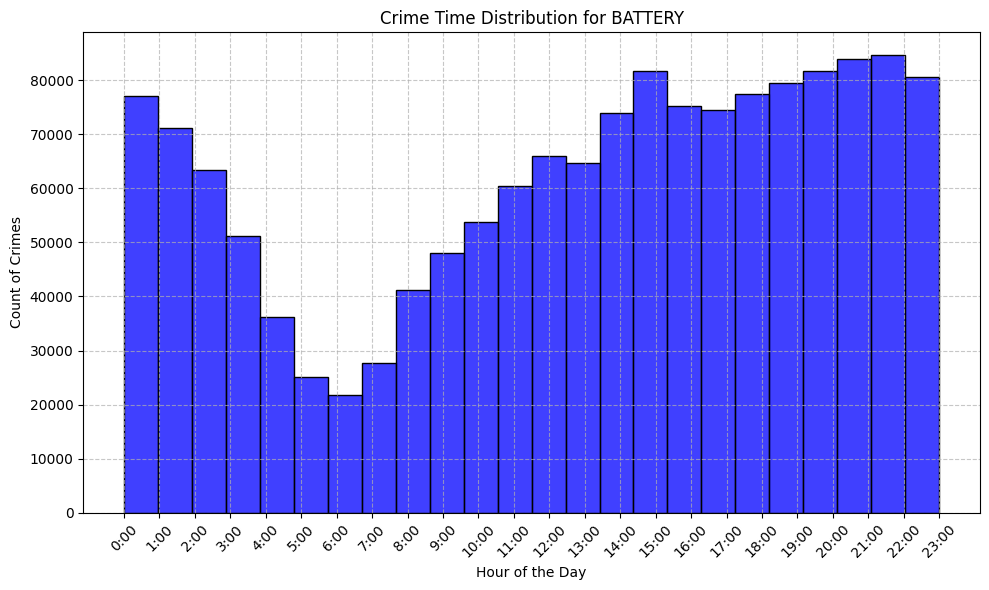

In [31]:
plot_crime_time_distribution("BATTERY")

In [ ]:
# Start to narrow down 

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

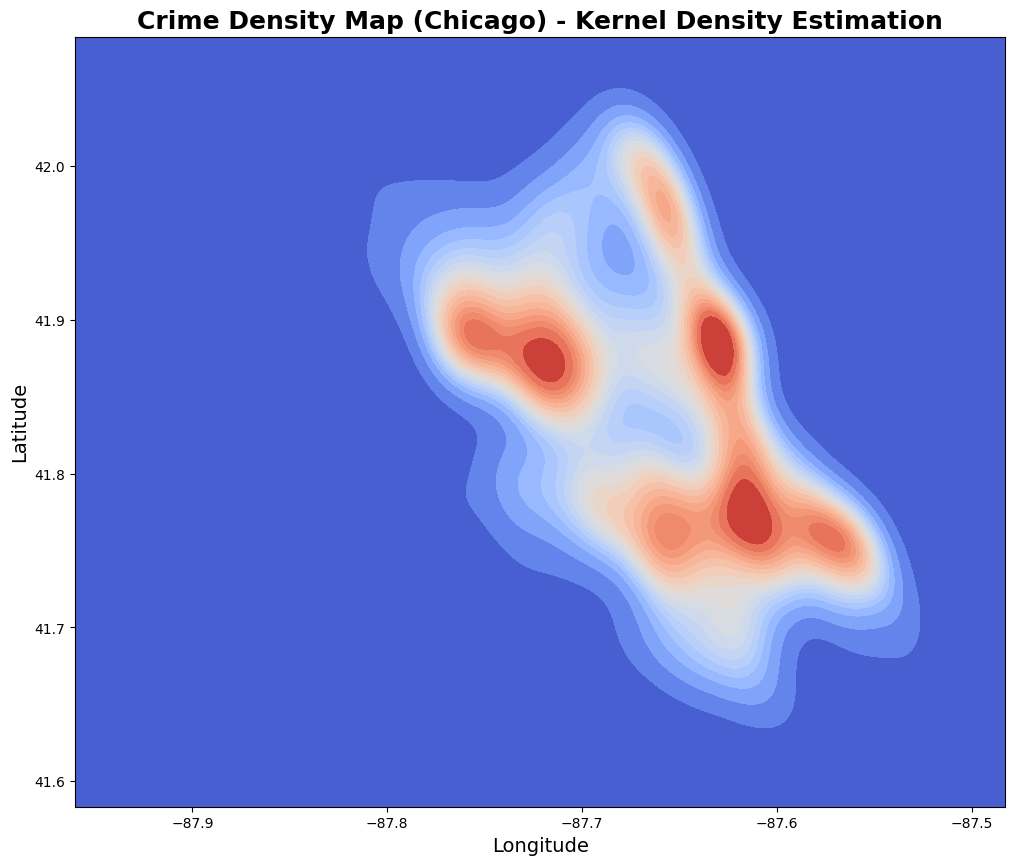

In [102]:
# Set the plot size
plt.figure(figsize=(12, 10))

# Create the plot with KDE for latitude and longitude
sns.kdeplot(x=crimes_2025['Longitude'], 
            y=crimes_2025['Latitude'], 
            fill=True, 
            thresh=0, 
            levels=20, 
            cmap='coolwarm')

# Set plot title and axis labels with larger font sizes
plt.title("Crime Density Map (Chicago) - Kernel Density Estimation", fontsize=18, weight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Add a color bar to show the density levels
plt.colorbar()

# Improve readability with a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout for better spacing and alignment
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
# Convert the DataFrame into a GeoDataFrame (GeoPandas)

gdf = gpd.GeoDataFrame(dataset, 
                        geometry=gpd.points_from_xy(dataset.Longitude, dataset.Latitude), 
                        crs="EPSG:4326")  # EPSG:4326 is for WGS84 lat/lon coordinate system

# Load a shapefile of Chicago (use your local file path)
# For example, you can use a shapefile of Chicago's boundaries that you download
# Chicago map shapefile URL: https://www2.census.gov/geo/tiger/2019/PL/15/06000US1703100000.shp (sample)

# Download or load your shapefile for Chicago
# Example: shapefile_path = "path_to_chicago_shapefile/chicago_shapefile.shp"
chicago_map = gpd.read_file("path_to_shapefile/chicago_boundaries.shp")

# Plot Chicago boundaries
fig, ax = plt.subplots(figsize=(10, 10))
chicago_map.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the density using seaborn's KDE plot over the map
sns.kdeplot(x=gdf['longitude'], y=gdf['latitude'], cmap='Blues', fill=True, thresh=0, levels=10, ax=ax)

# Adding titles and labels
plt.title("Crime Density in Chicago - Kernel Density Estimation", fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
!pip install folium

import pandas as pd
import folium
from folium.plugins import HeatMap



In [89]:
dangerous_locations = [
    'STREET',
    'ALLEY',
    'SIDEWALK',
    'PARK PROPERTY',
    'VACANT LOT / LAND',
    'BRIDGE',
    'LAKEFRONT / WATERFRONT / RIVERBANK',
    'GAS STATION',
    'PARKING LOT / GARAGE (NON RESIDENTIAL)',
    'CTA PLATFORM',
    'CTA STATION',
    'CTA BUS STOP',
    'CTA TRAIN',
    'AIRPORT EXTERIOR - NON-SECURE AREA',
    'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA',
    'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA',
    'VEHICLE - COMMERCIAL',
    'AUTO / BOAT / RV DEALERSHIP',
    'FACTORY / MANUFACTURING BUILDING',
    'OTHER RAILROAD PROPERTY / TRAIN DEPOT',
    'OTHER COMMERCIAL TRANSPORTATION'
]


In [95]:
# Create a folium map centered around Chicago (approximate center)
chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=12)

crimes_2025 = dataset[(dataset['Date'].dt.year == 2025) & (dataset["Primary Type"] == "BATTERY")]
crimes2025 = crimes_2025[crimes_2025["Location Description"].isin(dangerous_locations)]

# Prepare the data for HeatMap
heat_data = [[row['Latitude'], row['Longitude']] for _, row in crimes_2025.iterrows() if row["Latitude"] is not None]



# Add the HeatMap layer to the map with dynamic zoom behavior and custom gradient
heatmap = HeatMap(
    heat_data,
    min_opacity=0.5,   # Opacity at lower zoom levels
    radius=20,         # Set a fixed radius
    blur=10,           # Blur effect for smoother transitions
    max_zoom=20,       # Maximum zoom level
).add_to(chicago_map)



# Save the map as an HTML file
chicago_map.save("crime_density_map.html")


In [ ]:
cirm